# Load Important Libraries

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from random import randint
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
import numpy as np
import cv2
from keras.models import load_model

Using TensorFlow backend.


# To run on GPU, run the next cell

In [3]:
import tensorflow as tf
from keras import backend as K
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():
    
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus


K.tensorflow_backend._get_available_gpus()

['/device:GPU:0']

# To run on TPU, run the next cell

In [0]:
import tensorflow as tf
import os
import tensorflow_datasets as tfds

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# Load MNIST Data
## You could load yours dataset as well by changing the next cell

In [0]:
def load_dataset():
    # Load the Dataset
    (X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()
    # Reshape Dataset to have single channel
    X_train = X_train_orig.reshape((X_train_orig.shape[0], 28, 28, 1))
    X_test = X_test_orig.reshape((X_test_orig.shape[0], 28, 28, 1))
    # One Hot Encoding the output values
    Y_train = to_categorical(Y_train_orig)
    Y_test = to_categorical(Y_test_orig)
    
    return X_train, Y_train, X_test, Y_test

# Preprocessing of Data

In [0]:
def preprocessing(X_train, X_test):
    # Converting values from int to float
    X_train = X_train.astype('float')
    X_test = X_test.astype('float')
    # Normalization
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    return X_train, X_test

# Create Model and check its feasibility

In [0]:
def define_model():
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, kernel_size = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, kernel_size = (2, 2), activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))
    # Compile Model
    opt = SGD(learning_rate = 0.01, momentum = 0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [0]:
def evaluate_model(X_data, Y_data, n_folds = 5):
    # Initialize empty list
    scores, histories = list(), list()
    # Create Cross Validation
    kFold = KFold(n_folds, shuffle = True)
    # Enumerate Splits
    for i_train, i_test in kFold.split(X_data):
        # Define Model
        model = define_model()
        X_train, Y_train, X_test, Y_test = X_data[i_train], Y_data[i_train], X_data[i_test], Y_data[i_test]
        # Fit Model
        history = model.fit(X_train, Y_train, epochs = 10, batch_size = 32, validation_data = (X_test, Y_test), verbose = 1)
        # Evaluate Model
        _, acc = model.evaluate(X_test, Y_test, verbose = 1)
        print('> %.3f' % (acc*100.0))
        # Store Scores and Histories
        scores.append(acc)
        histories.append(history)
        
    return scores, histories

In [0]:
def performance(scores, histories):
    
    for i in range(len(histories)):
        # Plot Loss
        plt.subplot(2,2,1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color = 'blue', label = 'train')
        plt.plot(histories[i].history['val_loss'], color = 'red', label = 'test')
        # Plot Accuracy
        plt.subplot(2,2,2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color = 'blue', label = 'train')
        plt.plot(histories[i].history['val_accuracy'], color = 'red', label = 'test')
        
    plt.show()

    print('Accuracy: \nMean = %.3f, std = %.3f, n = %d' % (mean(scores)*100, std(scores)*100, len(scores)))

In [0]:
def check_model():
    # Collect all the above functions to check our Model
    X_train, Y_train, X_test, Y_test = load_dataset()
    X_train, X_test = preprocessing(X_train, X_test)
    scores, histories = evaluate_model(X_train, Y_train)
    performance(scores, histories)


11493376/11490434 [==============================] - 1s 0us/step
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 22s 468us/step - loss: 0.1526 - accuracy: 0.9520 - val_loss: 0.0586 - val_accuracy: 0.9827
Epoch 2/10
48000/48000 [==============================] - 16s 325us/step - loss: 0.0438 - accuracy: 0.9862 - val_loss: 0.0421 - val_accuracy: 0.9871
Epoch 3/10
48000/48000 [==============================] - 16s 333us/step - loss: 0.0276 - accuracy: 0.9916 - val_loss: 0.0413 - val_accuracy: 0.9871
Epoch 4/10
48000/48000 [==============================] - 16s 337us/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0466 - val_accuracy: 0.9865
Epoch 5/10
48000/48000 [==============================] - 16s 339us/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.0387 - val_accuracy: 0.9881
Epoch 6/10
48000/48000 [==============================] - 16s 324us/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 0.0375 - val_accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


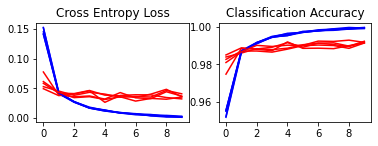

Accuracy: 
Mean = 99.165, std = 0.034, n = 5


In [9]:
# Run this cell to check our Model
check_model()

# Train the model on whole Dataset

In [0]:
def train_model():
    # Load Dataset
    X_train, Y_train, X_test, Y_test = load_dataset()
    X_train, X_test = preprocessing(X_train, X_test)
    # Training our Model on whole Dataset
    model = define_model()
    model.fit(X_train, Y_train, epochs = 30, batch_size = 32, verbose = 1)
    # Saving our Model
    model.save('Final.h5')
    _, acc = model.evaluate(X_test, Y_test, verbose = 1)
    print('Accuracy of our Model on Test Set: %.3f' % (acc*100))

In [11]:
# Run this cell to train our Model
train_model()

Epoch 1/30
60000/60000 [==============================] - 19s 315us/step - loss: 0.1292 - accuracy: 0.9595
Epoch 2/30
60000/60000 [==============================] - 18s 293us/step - loss: 0.0390 - accuracy: 0.9873
Epoch 3/30
60000/60000 [==============================] - 17s 291us/step - loss: 0.0239 - accuracy: 0.9926
Epoch 4/30
60000/60000 [==============================] - 18s 293us/step - loss: 0.0166 - accuracy: 0.9947
Epoch 5/30
60000/60000 [==============================] - 17s 291us/step - loss: 0.0124 - accuracy: 0.9961
Epoch 6/30
60000/60000 [==============================] - 17s 283us/step - loss: 0.0088 - accuracy: 0.9972
Epoch 7/30
60000/60000 [==============================] - 17s 282us/step - loss: 0.0060 - accuracy: 0.9981
Epoch 8/30
60000/60000 [==============================] - 17s 283us/step - loss: 0.0042 - accuracy: 0.9988
Epoch 9/30
60000/60000 [==============================] - 17s 283us/step - loss: 0.0034 - accuracy: 0.9989
Epoch 10/30
60000/60000 [============

# Predict the Digit from given Image

In [0]:
def prediction_preprocessing(filename):
    # Read the image
    img2 = cv2.imread(filename)
    # Convert image into grayscale
    gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Resize image to the dimension of input to our Model
    res = cv2.resize(gray, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
    # Preprocessing the image
    img = res.reshape(1, 28, 28, 1)
    img = img.astype('float')
    img = img / 255.0
    # Print the image
    plt.imshow(img2)

    return img

In [0]:
def prediction(filename):
    # Preprocess image
    img = prediction_preprocessing(filename)
    # Load Model
    model = load_model('Final.h5')
    # Predict output
    digit = model.predict_classes(img)
    # Print the digit
    print('Predicted Output: ', digit)

Predicted Output:  [7]


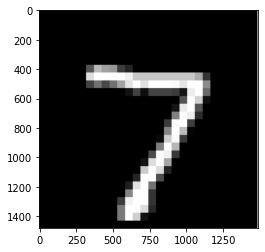

In [14]:
prediction('sample_image.png')